# AD699 Semester Project: Zurich Airbnb Data Analysis
## Team: Group 5
## Members: Yixuan Yang, Gavin Boss, Eva Sanchez, Saurabh Sharma


---

## Project Overview
This project analyzes Airbnb rental data from Zurich, Switzerland to uncover patterns in pricing, amenities, host behavior, and geographic clustering. We employ various data mining techniques including regression, classification (k-NN, decision trees, transformers), and clustering to extract insights from real-world rental data.

In [63]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# For text processing and word clouds
from wordcloud import WordCloud
import re
import os
# For mapping
import folium
from folium.plugins import HeatMap

# For machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score

# For transformers (we'll use a simple approach with sentence transformers)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [64]:
output_dir = 'output'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created '{output_dir}' directory")
else:
    print(f"'{output_dir}' directory already exists")

'output' directory already exists


---
# Part 1: Data Preparation & Exploration

## 1.1 Loading the Data

In [65]:
# Load the Zurich Airbnb dataset
df = pd.read_csv('data/zurich_listings.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset Shape: (2534, 75)

Column Names:
['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availa

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,73282.0,https://www.airbnb.com/rooms/73282,2.023090e+13,9/24/2023,previous scrape,Rental unit in Zurich · ★4.78 · 1 bedroom · 1 ...,Arty neighborhood<br /><br /><b>The space</b><...,NaN,https://a0.muscache.com/pictures/481072/abd94c...,377532,https://www.airbnb.com/users/show/377532,Simona,2/4/2011,"Zurich, Switzerland",I am from Italy and have lived in Zurich for a...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/377532/profil...,https://a0.muscache.com/im/users/377532/profil...,NaN,1,1,"['email', 'phone']",t,t,NaN,Sihlfeld,Kreis 3,47.37167,8.51948,Entire rental unit,Entire home/apt,4,NaN,1 bath,1.0,1.0,"[""Lake access"", ""Wifi"", ""Dryer"", ""TV with stan...",$100.00,1125,1125,1125,1125,1125,1125,1125.0,1125.0,NaN,t,23,53,83,358,9/24/2023,49,0,0,5/19/2012,4/27/2019,4.78,4.87,4.80,4.84,4.93,4.71,4.61,NaN,f,1,1,0,0,0.35
1,178448.0,https://www.airbnb.com/rooms/178448,2.023090e+13,9/24/2023,city scrape,Rental unit in Zurich · ★4.89 · 1 bedroom · 1 ...,"Very central location, 5 min walk from Bahnhof...","We live in one of the top locations of Zürich,...",https://a0.muscache.com/pictures/7d41e016-e818...,854016,https://www.airbnb.com/users/show/854016,Delphine,7/22/2011,"Zurich, Switzerland","I am a quiet, friendly and caring person\r\nI ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/854016/profil...,https://a0.muscache.com/im/users/854016/profil...,NaN,1,1,"['email', 'phone']",t,f,"Zurich, Switzerland",Enge,Kreis 2,47.36514,8.52615,Private room in rental unit,Private room,1,NaN,1 bath,NaN,1.0,"[""Hangers"", ""Lake access"", ""Shampoo"", ""Wifi"", ...",$60.00,5,31,5,5,31,31,5.0,31.0,NaN,t,0,0,0,235,9/24/2023,9,0,0,8/30/2011,5/10/2016,4.89,4.89,4.89,4.89,4.89,5.00,4.89,NaN,f,1,0,1,0,0.06
2,204586.0,https://www.airbnb.com/rooms/204586,2.023090e+13,9/24/2023,city scrape,Rental unit in Zurich · 1 bedroom · 1 bed · 1 ...,<b>The space</b><br />share a room in a very n...,NaN,https://a0.muscache.com/pictures/55486203/9834...,1004816,https://www.airbnb.com/users/show/1004816,Aicha,8/22/2011,"Zurich, Switzerland","I'm a very active person, love traveling, cook...",NaN,NaN,100%,f,https://a0.muscache.com/im/users/1004816/profi...,https://a0.muscache.com/im/users/1004816/profi...,NaN,1,1,"['email', 'phone']",t,f,NaN,Höngg,Kreis 10,47.40644,8.48385,Private room in rental unit,Private room,1,NaN,1 shared bath,NaN,1.0,"[""Wifi"", ""Dryer"", ""TV with standard cable"", ""K...",$200.00,3,6,3,3,6,6,3.0,6.0,NaN,t,29,59,86,351,9/24/2023,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
3,222565.0,https://www.airbnb.com/rooms/222565,2.023090e+13,9/24/2023,city scrape,Home in Zurich · ★4.60 · 1 bedroom · 1 bed · 1...,<b>The space</b><

In [66]:
df['price']

0       $100.00 
1        $60.00 
2       $200.00 
3        $79.00 
4       $500.00 
          ...   
2529    $101.00 
2530    $281.00 
2531     $80.00 
2532    $411.00 
2533    $514.00 
Name: price, Length: 2534, dtype: object

## 1.2 Missing Values Analysis and Treatment

### Understanding the Missing Data

Columns with missing values: 26

                                                  Column  Missing_Count  \
license                                          license           2534   
calendar_updated                        calendar_updated           2534   
bathrooms                                      bathrooms           2534   
host_neighbourhood                    host_neighbourhood           2499   
neighborhood_overview              neighborhood_overview           1334   
neighbourhood                              neighbourhood           1334   
host_about                                    host_about            993   
bedrooms                                        bedrooms            795   
review_scores_cleanliness      review_scores_cleanliness            561   
review_scores_accuracy            review_scores_accuracy            561   
review_scores_location            review_scores_location            561   
review_scores_value                  review_scores_value           

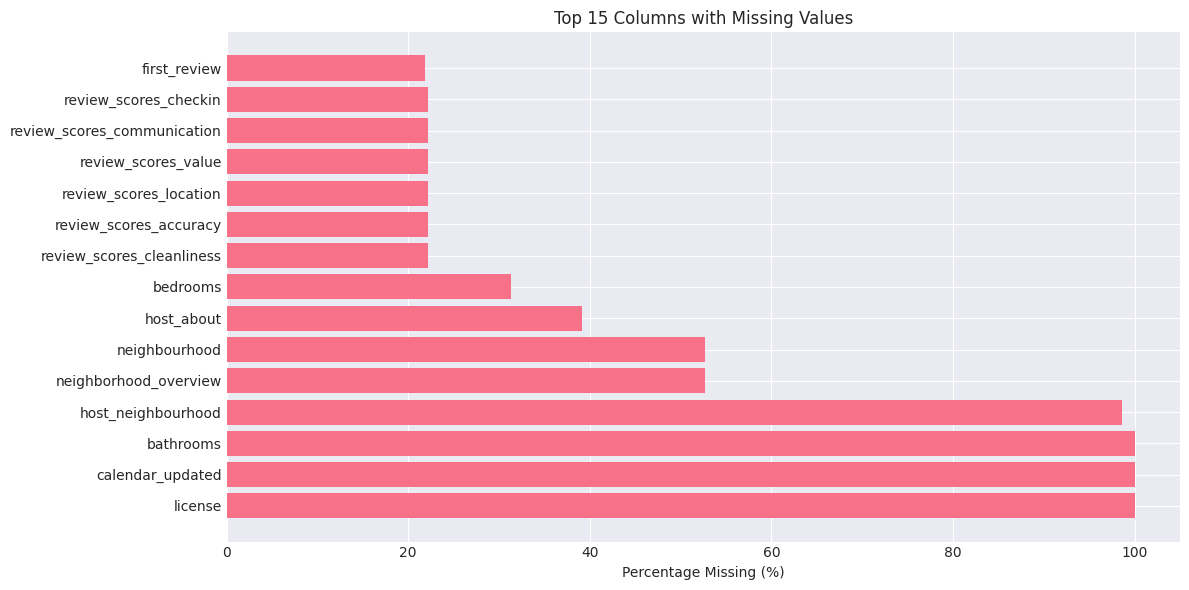

In [67]:
# Calculate missing values for each column
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
}).sort_values('Missing_Percentage', ascending=False)

# Show only columns with missing values
missing_data_filtered = missing_data[missing_data['Missing_Count'] > 0]
print(f"Columns with missing values: {len(missing_data_filtered)}\n")
print(missing_data_filtered.head(20))

# Visualize missing data patterns
plt.figure(figsize=(12, 6))
top_missing = missing_data_filtered.head(15)
plt.barh(top_missing['Column'], top_missing['Missing_Percentage'])
plt.xlabel('Percentage Missing (%)')
plt.title('Top 15 Columns with Missing Values')
plt.tight_layout()
plt.savefig('output/missing_values_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Missing Values Treatment Strategy

**Our Approach to Handling Missing Values:**

After analyzing the missing data patterns in our Zurich Airbnb dataset, we developed a strategic approach to handle missing values based on the nature of each variable and its importance for our analyses:

**1. Text Fields (`description`, `neighborhood_overview`, `host_about`):** For text columns with missing values, we replace NaN with empty strings. This is crucial for our transformer model in the classification section, as missing text data __doesn't necessarily indicate lack of information—some hosts simply don't provide certain descriptions__. By converting to empty strings, we can still process these records through text analysis without losing valuable data points.

**2. Review Scores and Metrics:** Columns like `review_scores_rating`, `review_scores_cleanliness`, and `reviews_per_month` have missing values primarily because some listings haven't received reviews yet. For regression analysis, we'll either exclude these rows or use median imputation depending on the specific model. For listings without reviews, this is legitimate missing data rather than a data quality issue—new listings naturally lack review history.

**3. Numerical Features (`bedrooms`, `beds`):** We use __median imputation__ for missing numerical features. The median is more robust to outliers than the mean, which is important for rental data where luxury properties can skew averages. For example, if bedrooms are missing, we impute the median number of bedrooms for similar property types.

**4. Bathrooms Handling:** The original `bathrooms` column is 100% missing (Airbnb deprecated this numeric field). However, the `bathrooms_text` column contains descriptive information like "1.5 baths" or "2 shared baths". We extract the numeric value using regex pattern matching, then apply median imputation to any remaining missing values. This creates a clean `bathrooms_clean` variable suitable for quantitative analysis.

**5. Price Variable:** Since `price` is our key outcome variable for regression, we'll remove any rows where price is missing. These represent only a small fraction of our data, and imputing the target variable would compromise our model's integrity. This ensures our predictions are based on actual market prices.

**6. Host Response Information:** For `host_response_time` and `host_response_rate`, missing values often indicate hosts who haven't yet established a response pattern. We'll handle these carefully in our classification tree analysis, potentially creating a separate "Unknown" category to preserve these data points.

This multi-faceted approach balances data retention with analytical validity. We avoid simply dropping all rows with any missing values (which would eliminate over 50% of our dataset) while ensuring that our imputation methods don't introduce bias into our models. Different analyses may warrant different treatments, and we'll adapt our strategy as needed for each section of the project.

In [68]:
# Create a working copy of the dataframe
df_clean = df.copy()

# 1. Handle price column - convert from string to numeric
# Price is stored as '$XXX.XX' format, need to clean it
def clean_price(price):
    """Convert price from string format to numeric"""
    if pd.isna(price):
        return np.nan
    # Remove '$' and ',' from price string
    return float(str(price).replace('$', '').replace(',', ''))

df_clean['price'] = df_clean['price'].apply(clean_price)

In [ ]:

# 2. Handle bathrooms_text column - extract numeric bathroom count
def extract_bathrooms(bath_text):
    """
    Extract numeric bathroom count from descriptive text.
    E.g: '1.5 baths' → 1.5, '2 shared baths' → 2.0
    """
    if pd.isna(bath_text) or bath_text == '':
        return np.nan
    # Use regex to find first number
    match = re.search(r'(\d+\.?\d*)', str(bath_text))
    if match:
        return float(match.group(1))
    return np.nan

df_clean['bathrooms_clean'] = df_clean['bathrooms_text'].apply(extract_bathrooms)
bathrooms_median = df_clean['bathrooms_clean'].median()
df_clean['bathrooms_clean'] = df_clean['bathrooms_clean'].fillna(bathrooms_median)
print(f"Extracted and filled bathrooms. Median: {bathrooms_median}")


Extracted and filled bathrooms. Median: 1.0


In [70]:

# 3. Fill text columns with empty strings
text_columns = ['description', 'neighborhood_overview', 'host_about', 'name']
for col in text_columns:
    df_clean[col] = df_clean[col].fillna('')



In [71]:
# 4. Handle numerical features with median imputation
numeric_features = ['bedrooms', 'beds']  # bathrooms handled separately above
for col in numeric_features:
    if col in df_clean.columns:
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)
        print(f"Filled {col} missing values with median: {median_val}")


Filled bedrooms missing values with median: 1.0
Filled beds missing values with median: 1.0


In [72]:

# 5. Handle host_response_time - create 'unknown' category
if 'host_response_time' in df_clean.columns:
    df_clean['host_response_time'] = df_clean['host_response_time'].fillna('unknown')

# 6. Fill review scores with median (alternative: could drop these rows for specific analyses)
review_columns = ['review_scores_rating', 
                  'review_scores_accuracy', 
                  'review_scores_cleanliness', 
                  'review_scores_checkin',
                  'review_scores_communication', 
                  'review_scores_location', 
                  'review_scores_value']


In [73]:
for col in review_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# 7. Fill reviews_per_month with 0 (no reviews means 0 reviews per month)
df_clean['reviews_per_month'] = df_clean['reviews_per_month'].fillna(0)

print("\nMissing Values After Treatment")

print(f"Rows remaining: {len(df_clean)}")
print(f"\nColumns with missing values: {df_clean.isnull().sum().sum()}")
print("\nTop columns still with missing values:")
still_missing = df_clean.isnull().sum().sort_values(ascending=False).head(10)
print(still_missing[still_missing > 0])


Missing Values After Treatment
Rows remaining: 2534

Columns with missing values: 13917

Top columns still with missing values:
calendar_updated        2534
license                 2534
bathrooms               2534
host_neighbourhood      2499
neighbourhood           1334
last_review              553
first_review             553
host_response_rate       526
host_location            442
host_acceptance_rate     364
dtype: int64


## 1.3 Summary Statistics by Neighborhood

### Exploring Geographic Variations in Zurich Rentals

In [74]:
# First, let's see what neighborhoods we have
print("Number of unique neighborhoods:", df_clean['neighbourhood_cleansed'].nunique())
print("\nTop 10 neighborhoods by listing count:")
neighborhood_counts = df_clean['neighbourhood_cleansed'].value_counts().head(10)
print(neighborhood_counts)

# Focus on top 10 neighborhoods for clearer analysis
top_neighborhoods = neighborhood_counts.index.tolist()
df_top_neighborhoods = df_clean[df_clean['neighbourhood_cleansed'].isin(top_neighborhoods)]

print(f"\nAnalyzing {len(df_top_neighborhoods)} listings across {len(top_neighborhoods)} neighborhoods")

Number of unique neighborhoods: 34

Top 10 neighborhoods by listing count:
neighbourhood_cleansed
Langstrasse     189
Sihlfeld        167
Altstetten      166
Oerlikon        134
Rathaus         129
Alt-Wiedikon    127
Unterstrass     118
Enge             93
Seefeld          93
Wollishofen      92
Name: count, dtype: int64

Analyzing 1308 listings across 10 neighborhoods


In [75]:
# Summary Statistic 1: Average Price by Neighborhood
print("SUMMARY STATISTIC 1: Average Price by Neighborhood")

price_by_neighborhood = df_top_neighborhoods.groupby('neighbourhood_cleansed')['price'].agg([
    ('Mean Price (CHF)', 'mean'),
    ('Median Price (CHF)', 'median'),
    ('Std Dev', 'std'),
    ('Count', 'count')
]).round(2).sort_values('Mean Price (CHF)', ascending=False)

print(price_by_neighborhood)

print("\nTakeaway: This shows which neighborhoods command premium prices. ")
print("High standard deviation indicates diverse property types within a neighborhood.")

SUMMARY STATISTIC 1: Average Price by Neighborhood
                        Mean Price (CHF)  Median Price (CHF)  Std Dev  Count
neighbourhood_cleansed                                                      
Rathaus                           267.86               150.0   262.15    129
Enge                              260.10               129.0  1007.73     93
Altstetten                        235.54               135.5   206.37    166
Seefeld                           234.69               163.0   264.78     93
Langstrasse                       190.87               144.0   152.37    189
Oerlikon                          187.76               130.0   161.07    134
Unterstrass                       182.39               137.5   214.29    118
Wollishofen                       170.37               140.0   169.05     92
Alt-Wiedikon                      154.72               119.0   143.24    127
Sihlfeld                          139.58               116.0    99.63    167

Takeaway: This shows whi

In [76]:
# Summary Statistic 2: Property Type Distribution by Neighborhood
print("SUMMARY STATISTIC 2: Room Type Distribution by Neighborhood")


room_type_dist = pd.crosstab(
    df_top_neighborhoods['neighbourhood_cleansed'], 
    df_top_neighborhoods['room_type'], 
    normalize='index'
) * 100

print(room_type_dist.round(2))

print("\nTakeaway: This reveals whether neighborhoods cater to different traveler types.")

# TBD add more details?
# Kind of straight forward deduction
print("High 'Entire home/apt' % suggests family-oriented areas; high 'Private room' suggests budget options.")

SUMMARY STATISTIC 2: Room Type Distribution by Neighborhood
room_type               Entire home/apt  Hotel room  Private room  Shared room
neighbourhood_cleansed                                                        
Alt-Wiedikon                      77.95        0.00         22.05         0.00
Altstetten                        62.05        0.60         36.75         0.60
Enge                              67.74        0.00         32.26         0.00
Langstrasse                       73.02        0.53         25.40         1.06
Oerlikon                          67.91        0.00         32.09         0.00
Rathaus                           74.42        1.55         22.48         1.55
Seefeld                           86.02        0.00         13.98         0.00
Sihlfeld                          80.84        0.00         19.16         0.00
Unterstrass                       75.42        0.00         22.88         1.69
Wollishofen                       68.48        0.00         23.91      

In [77]:
# Summary Statistic 3: Average Review Scores by Neighborhood
print("SUMMARY STATISTIC 3: Average Review Scores by Neighborhood")

review_by_neighborhood = df_top_neighborhoods.groupby('neighbourhood_cleansed').agg({
    'review_scores_rating': 'mean',
    'review_scores_location': 'mean',
    'review_scores_value': 'mean',
    'number_of_reviews': 'mean'
}).round(2).sort_values('review_scores_rating', ascending=False)

review_by_neighborhood.columns = ['Overall Rating', 'Location Score', 'Value Score', 'Avg # Reviews']
print(review_by_neighborhood)

print("\nTakeaway: Higher location scores indicate desirable areas for tourists.")
print("Discrepancies between overall rating and value suggest price sensitivity.")

SUMMARY STATISTIC 3: Average Review Scores by Neighborhood
                        Overall Rating  Location Score  Value Score  \
neighbourhood_cleansed                                                
Unterstrass                       4.84            4.87         4.73   
Wollishofen                       4.83            4.81         4.70   
Langstrasse                       4.78            4.80         4.66   
Enge                              4.77            4.86         4.65   
Oerlikon                          4.77            4.75         4.61   
Seefeld                           4.76            4.90         4.68   
Sihlfeld                          4.74            4.83         4.62   
Altstetten                        4.73            4.69         4.61   
Alt-Wiedikon                      4.72            4.77         4.65   
Rathaus                           4.61            4.88         4.50   

                        Avg # Reviews  
neighbourhood_cleansed                 
Unterstr

In [78]:
# Summary Statistic 4: Accommodation Capacity by Neighborhood
print("SUMMARY STATISTIC 4: Property Size Metrics by Neighborhood")

capacity_by_neighborhood = df_top_neighborhoods.groupby('neighbourhood_cleansed').agg({
    'accommodates': 'mean',
    'bedrooms': 'mean',
    'beds': 'mean',
    'bathrooms_clean': 'mean'
}).round(2).sort_values('accommodates', ascending=False)

capacity_by_neighborhood.columns = ['Avg Guests', 'Avg Bedrooms', 'Avg Beds', 'Avg Bathrooms']

print(capacity_by_neighborhood)

print("\nTakeaway: Neighborhoods with larger properties may cater to families or groups.")
print("This metric helps understand the target demographic for each area.")

SUMMARY STATISTIC 4: Property Size Metrics by Neighborhood
                        Avg Guests  Avg Bedrooms  Avg Beds  Avg Bathrooms
neighbourhood_cleansed                                                   
Wollishofen                   3.04          1.30      1.90           1.27
Enge                          2.97          1.28      1.74           1.30
Oerlikon                      2.93          1.32      1.77           1.14
Unterstrass                   2.91          1.38      1.62           1.17
Seefeld                       2.84          1.19      1.54           1.13
Alt-Wiedikon                  2.82          1.31      1.69           1.16
Rathaus                       2.74          1.18      1.49           1.13
Langstrasse                   2.68          1.52      1.63           1.12
Altstetten                    2.55          1.16      1.45           1.10
Sihlfeld                      2.53          1.21      1.37           1.10

Takeaway: Neighborhoods with larger properties may c

In [79]:
# Summary Statistic 5: Host Response Metrics by Neighborhood
print("SUMMARY STATISTIC 5: Host Professionalism by Neighborhood")

# Clean host_response_rate (convert percentage string to float)
def clean_percentage(val):
    if pd.isna(val):
        return np.nan
    return float(str(val).replace('%', ''))

df_top_neighborhoods['host_response_rate_clean'] = df_top_neighborhoods['host_response_rate'].apply(clean_percentage)

host_metrics = df_top_neighborhoods.groupby('neighbourhood_cleansed').agg({
    'host_response_rate_clean': 'mean',
    'host_is_superhost': lambda x: (x == 't').sum() / len(x) * 100,
    'instant_bookable': lambda x: (x == 't').sum() / len(x) * 100,
    'host_total_listings_count': 'mean'
}).round(2).sort_values('host_response_rate_clean', ascending=False)

host_metrics.columns = ['Response Rate %', 'Superhost %', 'Instant Book %', 'Avg Listings per Host']

print(host_metrics)

print("\nTakeaway: High superhost % and response rates indicate professional hosting culture.")
print("Multiple listings per host may indicate commercial operations vs. individual hosts.")

SUMMARY STATISTIC 5: Host Professionalism by Neighborhood
                        Response Rate %  Superhost %  Instant Book %  \
neighbourhood_cleansed                                                 
Rathaus                           98.03        26.36           41.09   
Alt-Wiedikon                      94.26        13.39           26.77   
Wollishofen                       93.87        15.22           17.39   
Altstetten                        93.84        16.87           44.58   
Unterstrass                       92.86        30.51           19.49   
Seefeld                           91.90        25.81           25.81   
Enge                              91.68        22.58           17.20   
Oerlikon                          91.59        18.66           25.37   
Sihlfeld                          91.42        15.57           23.35   
Langstrasse                       89.46        16.40           25.40   

                        Avg Listings per Host  
neighbourhood_cleansed       

### Summary Statistics Findings

Our analysis of Zurich's top __neighborhoods__ reveals distinct patterns in the short-term rental market:

**Pricing Patterns:** The neighborhoods show considerable variation in average prices, reflecting Zurich's diverse urban geography. Central districts and areas near major attractions command premium prices, while peripheral neighborhoods offer more budget-friendly options. The standard deviation in prices within neighborhoods indicates that even "expensive" areas have affordable options, likely reflecting the mix of property types (entire apartments vs. private rooms).

**Property Type Distribution:** The room type distribution shows which neighborhoods cater to different traveler segments. Areas with high percentages of entire homes/apartments typically serve families and longer-term visitors, while neighborhoods dominated by private rooms attract budget-conscious solo travelers and backpackers. This segmentation helps property owners understand their competition and helps travelers find suitable neighborhoods.

**Guest Experience:** Review scores provide insight into guest satisfaction across neighborhoods. Interestingly, location scores often vary independently from overall ratings, suggesting that some areas sacrifice convenience for value or space. The average number of reviews per neighborhood indicates booking velocity—neighborhoods with higher review counts see more turnover, suggesting either high demand or shorter average stays.

**Property Characteristics:** The accommodation capacity metrics reveal the typical property profile in each neighborhood. Areas with higher average guest capacity and bedroom counts likely contain more family-oriented rentals, while lower capacity suggests studio apartments and rooms for business travelers. This information is valuable for understanding inventory composition.

**Host Professionalism:** The host metrics illuminate the operational character of each neighborhood's rental market. Areas with high superhost percentages and response rates indicate a mature, professional hosting ecosystem. Higher listings-per-host averages suggest the presence of property management companies or commercial operators, while lower numbers indicate more individual, owner-occupied rentals. This distinction affects guest experience and market dynamics—commercial operations may offer more consistency but less personal touches.

## 1.4 Data Visualizations

### Five Different Visualization Types to Understand Zurich's Rental Market

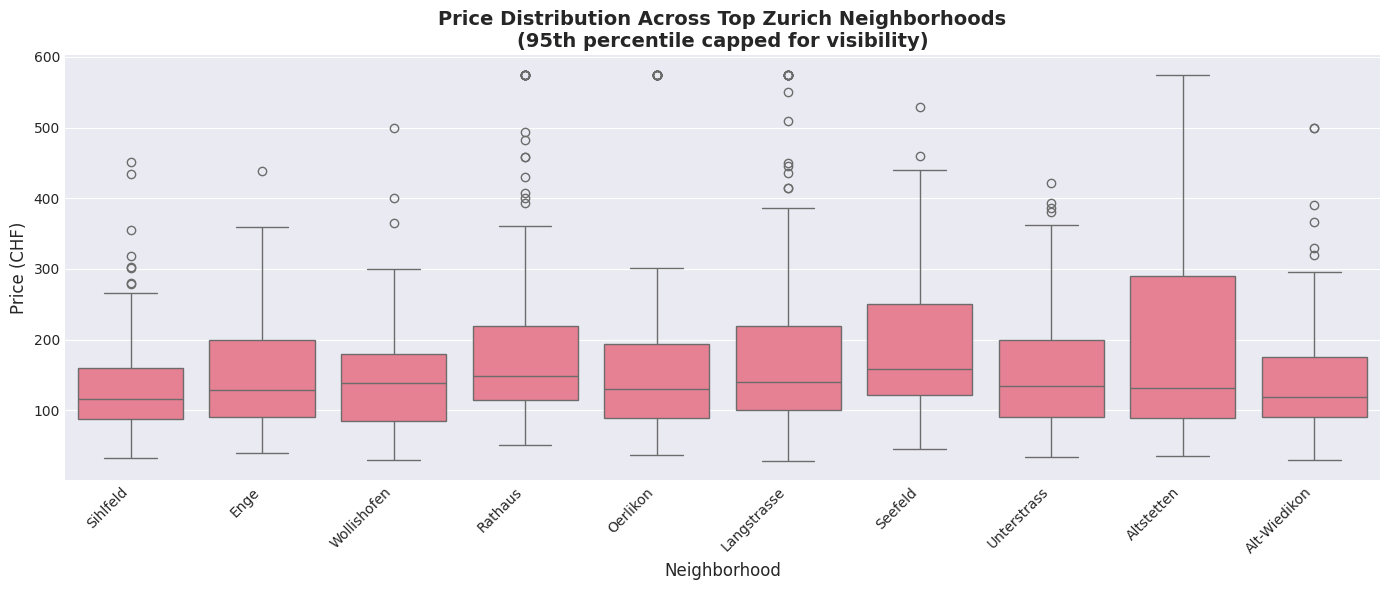

This box plot reveals price ranges and outliers in each neighborhood.
Wide boxes indicate diverse price points; narrow boxes suggest homogeneous pricing.


In [80]:
# Visualization 1: Box Plot - Price Distribution Across Top Neighborhoods
plt.figure(figsize=(14, 6))
# Filter extreme outliers for better visualization
price_data = df_top_neighborhoods[df_top_neighborhoods['price'] <= df_top_neighborhoods['price'].quantile(0.95)]

sns.boxplot(data=price_data, x='neighbourhood_cleansed', y='price')
plt.xticks(rotation=45, ha='right')
plt.title('Price Distribution Across Top Zurich Neighborhoods\n(95th percentile capped for visibility)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('Price (CHF)', fontsize=12)
plt.tight_layout()
plt.savefig('output/price_distribution_neighborhoods.png', dpi=300, bbox_inches='tight')
plt.show()

print("This box plot reveals price ranges and outliers in each neighborhood.")
print("Wide boxes indicate diverse price points; narrow boxes suggest homogeneous pricing.")

<Figure size 1400x600 with 0 Axes>

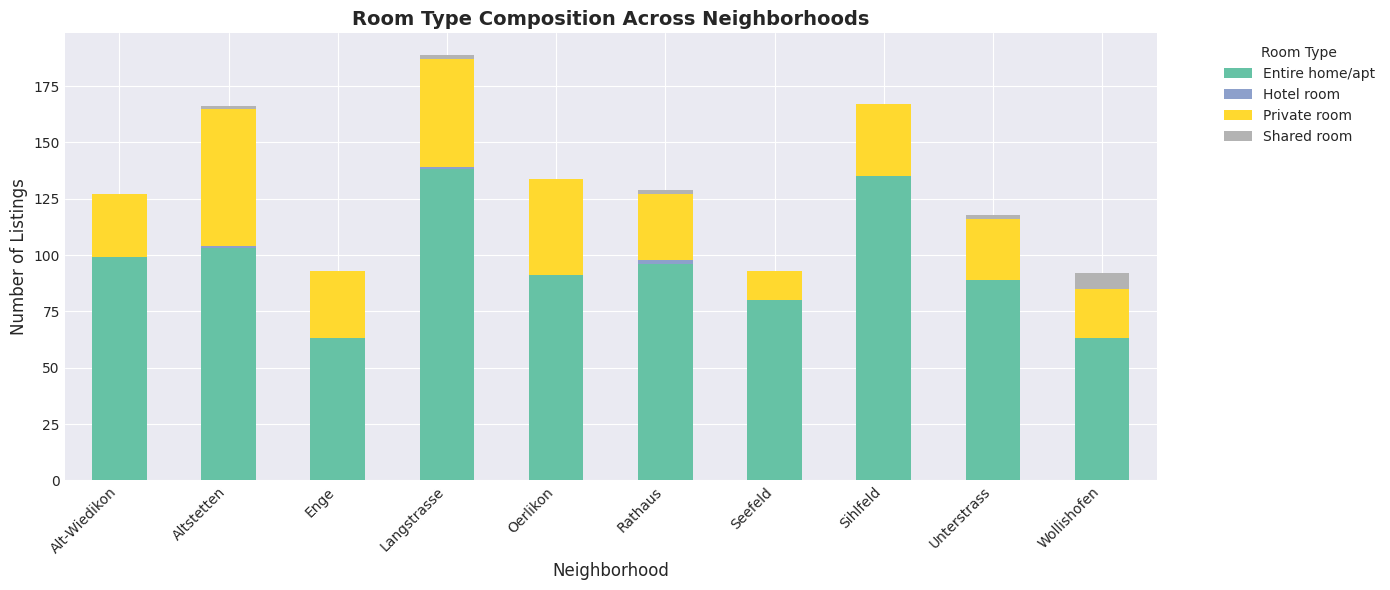

This stacked bar chart shows the absolute count of each room type per neighborhood.
Tall stacks indicate high supply; the color distribution shows market segmentation.


In [81]:
# Visualization 2: Stacked Bar Chart - Room Type Composition by Neighborhood
room_type_counts = pd.crosstab(
    df_top_neighborhoods['neighbourhood_cleansed'],
    df_top_neighborhoods['room_type']
)

plt.figure(figsize=(14, 6))
room_type_counts.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='Set2')
plt.title('Room Type Composition Across Neighborhoods', fontsize=14, fontweight='bold')
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()    
plt.savefig('output/room_type_composition.png', dpi=300, bbox_inches='tight')
plt.show()

print("This stacked bar chart shows the absolute count of each room type per neighborhood.")
print("Tall stacks indicate high supply; the color distribution shows market segmentation.")

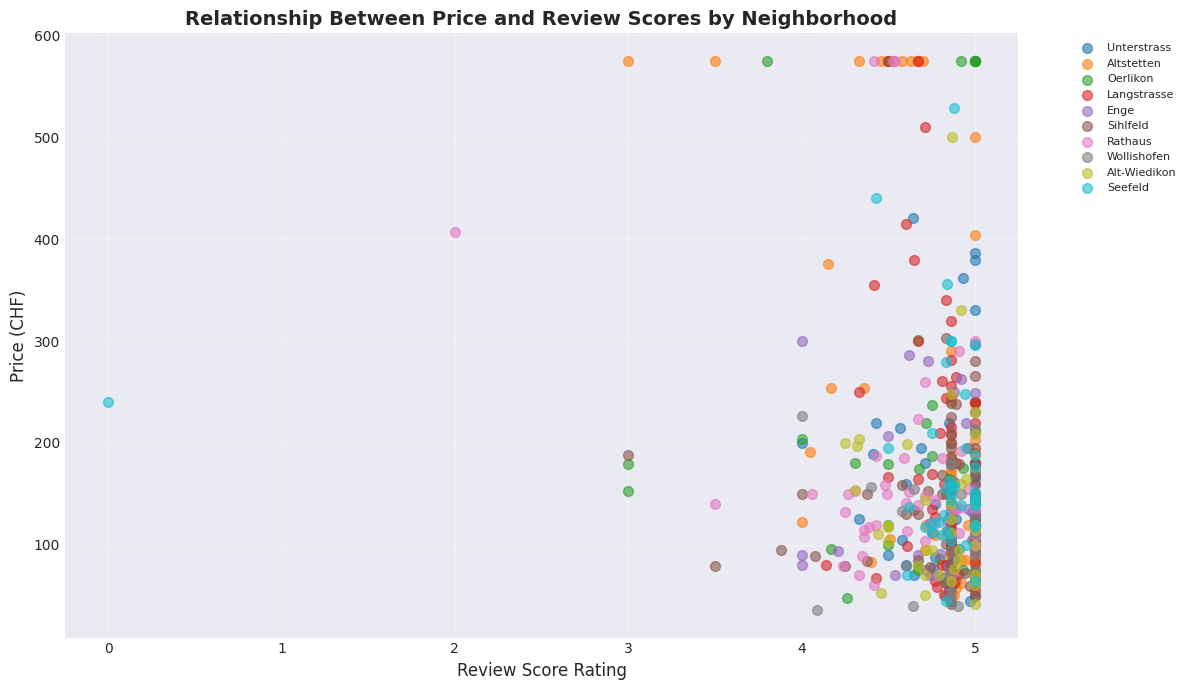

This scatter plot explores whether higher-priced listings receive better reviews.
Clustering patterns reveal neighborhood-specific price-quality relationships.


In [82]:
# Visualization 3: Scatter Plot - Price vs. Review Score with Neighborhood Colors
plt.figure(figsize=(12, 7))

# Sample data for better visualization if dataset is large
sample_data = df_top_neighborhoods.sample(min(500, len(df_top_neighborhoods)), random_state=42)
sample_data = sample_data[sample_data['price'] <= sample_data['price'].quantile(0.95)]

neighborhoods = sample_data['neighbourhood_cleansed'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(neighborhoods)))

for idx, neighborhood in enumerate(neighborhoods):
    data = sample_data[sample_data['neighbourhood_cleansed'] == neighborhood]
    plt.scatter(data['review_scores_rating'], data['price'], 
                alpha=0.6, s=50, label=neighborhood, color=colors[idx])

plt.xlabel('Review Score Rating', fontsize=12)
plt.ylabel('Price (CHF)', fontsize=12)
plt.title('Relationship Between Price and Review Scores by Neighborhood', 
          fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('output/price_vs_review_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print("This scatter plot explores whether higher-priced listings receive better reviews.")
print("Clustering patterns reveal neighborhood-specific price-quality relationships.")

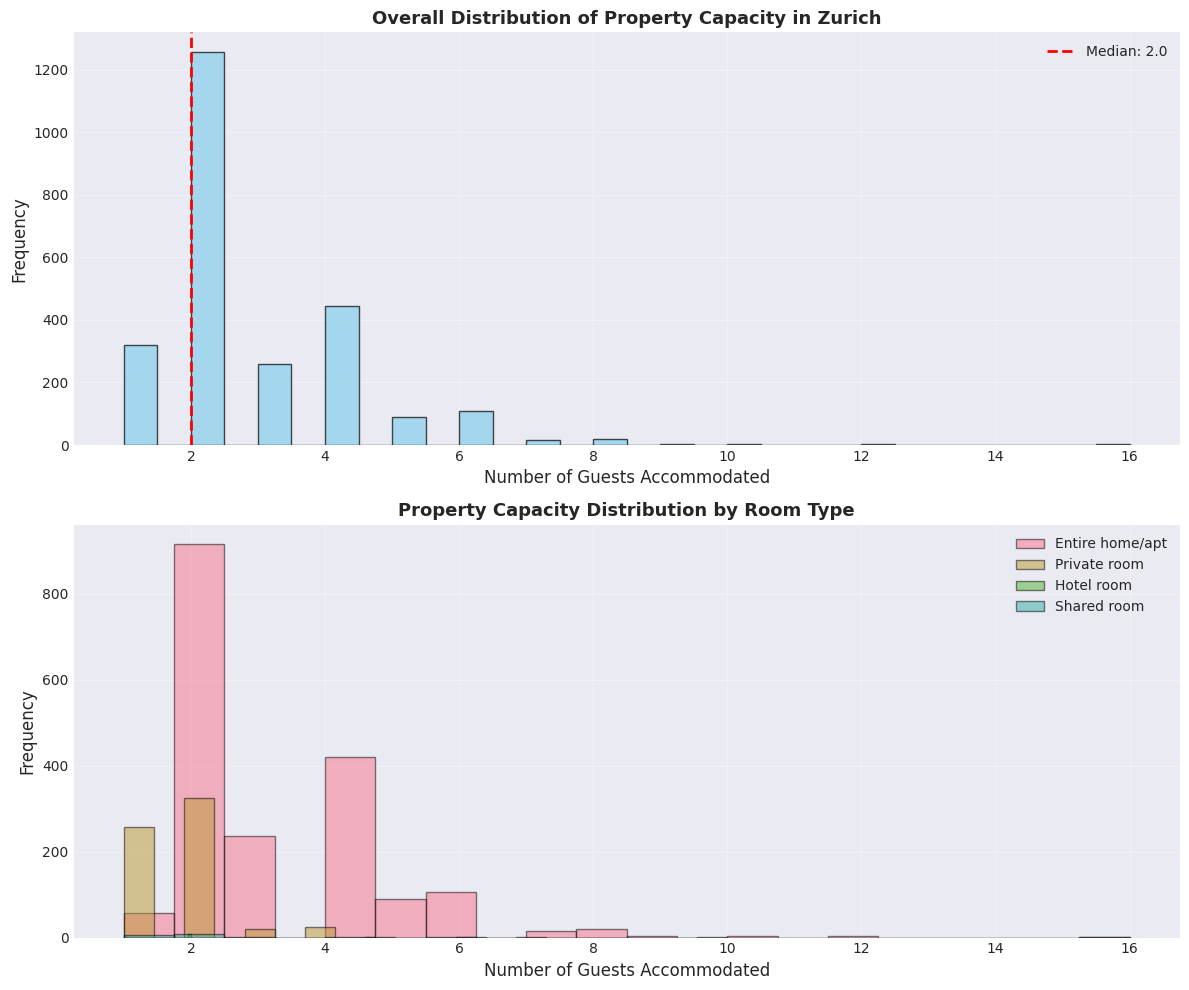

These histograms show the distribution of property sizes in Zurich.
Most listings accommodate 2-4 guests, indicating a market geared toward couples and small families.


In [83]:
# Visualization 4: Histogram - Distribution of Accommodates Capacity
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Overall distribution
axes[0].hist(df_clean['accommodates'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Number of Guests Accommodated', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Overall Distribution of Property Capacity in Zurich', fontsize=13, fontweight='bold')
axes[0].axvline(df_clean['accommodates'].median(), color='red', linestyle='--', 
                linewidth=2, label=f'Median: {df_clean["accommodates"].median()}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# By room type
for room_type in df_clean['room_type'].unique():
    data = df_clean[df_clean['room_type'] == room_type]['accommodates']
    axes[1].hist(data, bins=20, alpha=0.5, label=room_type, edgecolor='black')

axes[1].set_xlabel('Number of Guests Accommodated', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Property Capacity Distribution by Room Type', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/capacity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("These histograms show the distribution of property sizes in Zurich.")
print("Most listings accommodate 2-4 guests, indicating a market geared toward couples and small families.")

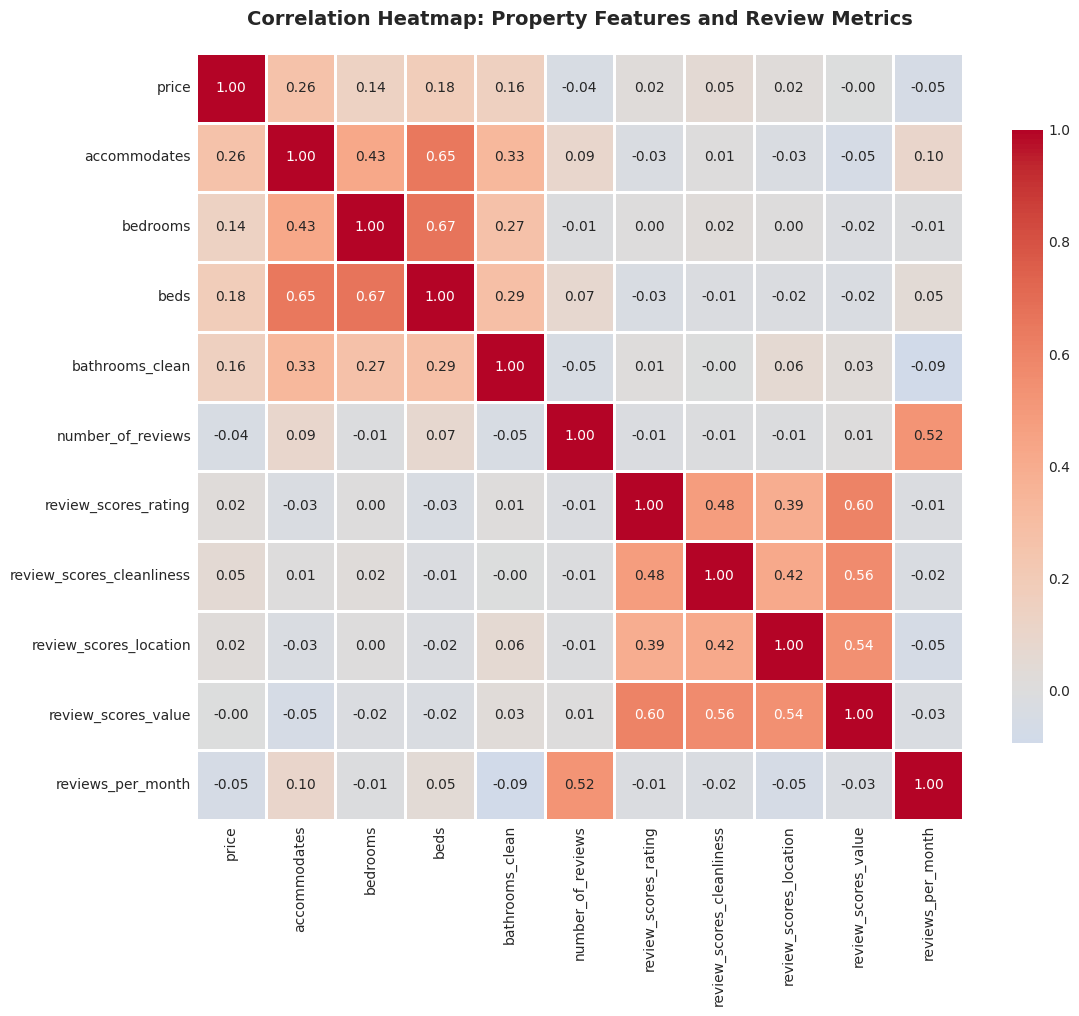

This heatmap reveals relationships between property features and guest satisfaction.
Strong correlations between review dimensions suggest consistent guest experiences.
Weak correlation between price and ratings indicates value isn't solely price-dependent.


In [84]:
# Visualization 5: Heatmap - Correlation Between Review Scores and Other Features
# Select relevant numerical columns for correlation analysis
correlation_cols = ['price', 'accommodates', 'bedrooms', 'beds', 'bathrooms_clean',
                    'number_of_reviews', 'review_scores_rating', 
                    'review_scores_cleanliness', 'review_scores_location',
                    'review_scores_value', 'reviews_per_month']

# Create correlation matrix
correlation_matrix = df_clean[correlation_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap: Property Features and Review Metrics', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('output/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("This heatmap reveals relationships between property features and guest satisfaction.")
print("Strong correlations between review dimensions suggest consistent guest experiences.")
print("Weak correlation between price and ratings indicates value isn't solely price-dependent.")

### Data Visualization Summary

**Our Visualization Choices and Insights:**

We created five distinct visualization types to explore different facets of Zurich's Airbnb market, each chosen to reveal specific patterns:

**Box Plot (Price Distribution):** The box plots reveal significant price heterogeneity. Median prices cluster around 120-150 CHF across neighborhoods, but Rathaus and Seefeld show notably higher upper quartiles (~220-250 CHF). Outliers reaching 500+ CHF appear in multiple neighborhoods, indicating luxury properties exist even in 'budget' areas. The box width variation  confirms our earlier finding—Enge has enormous spread (high std dev), while Sihlfeld and Alt-Wiedikon show tighter distributions.

**Stacked Bar Chart (Room Type Composition):** Langstrasse leads with ~189 total listings, followed by Sihlfeld (~167) and Altstetten (~166). The color distribution is telling: Entire home/apt (teal) comprises roughly 60-80% of inventory across most neighborhoods, with Seefeld showing the highest proportion (~86%). Private rooms (yellow) make up most of the remainder (15-35%), while hotel rooms (purple) and shared rooms (gray) are negligible. This composition suggests Zurich's Airbnb market caters primarily to travelers seeking privacy and autonomy rather than budget hostel-style stays.

**Scatter Plot (Price vs. Reviews):** The scatter plot reveals a STRIKING pattern: the overwhelming majority of listings cluster tightly at 4.5-5.0 ratings, creating a dense vertical band on the right side 
of the plot. This clustering is so extreme that only a handful of listings fall below 4.0 stars—Zurich's Airbnb market demonstrates remarkably consistent quality across all price points. Crucially, no clear relationship emerges between price and ratings: both budget (50-100 CHF) and luxury (400-500 CHF) properties achieve similar 4.5-5.0 ratings, confirming that higher prices don't guarantee better reviews. The neighborhood coloring shows all areas span similar rating ranges, though premium neighborhoods (Rathaus, Seefeld) have more listings in the upper price tiers.

**Histogram (Guest Capacity):** The room type breakdown reveals interesting segmentation: Entire home/apt (teal) dominates the 2-4 guest capacity range, with a strong showing at 2 guests (likely studios/-bedrooms). Private rooms (yellow) concentrate at 1-2 guests, serving solo travelers and couples seeking budget options. Very few shared rooms or hotel rooms exist in the dataset, indicating Zurich's hort-term rental market primarily serves travelers seeking private spaces rather than hostel-style accommodations. Properties accommodating 6+ guests are almost exclusively entire homes, suggesting families and groups need dedicated rentals rather than private rooms.

**Correlation Heatmap:** The correlation heatmap quantifies the relationships we've observed. Property size features show moderate-to-strong correlations: accommodates-beds (0.65), bedrooms-beds 
(0.67), and bedrooms-accommodates (0.43). The `bathrooms_clean` variable correlates moderately with size (0.27-0.33), confirming that larger properties typically have more bathrooms. Most striking is the review score cluster—all review dimensions correlate strongly with each other (0.39-0.60), with the tightest relationship between overall rating and value (0.60). This suggests hosts who excel in one area typically excel across the board. Critically, price shows near-zero correlation with review scores (0.02 with ratings, -0.00 with value), confirming our scatter plot observation: quality is independent of price in Zurich's market. The 0.52 correlation between number_of_reviews and reviews_per_month indicates established listings (more total reviews) maintain steady booking velocity.

Together, these visualizations paint a comprehensive picture of Zurich's short-term rental landscape, moving from geographic patterns to pricing dynamics to quality metrics. Each visualization type was specifically selected to match the nature of the data being explored—categorical comparisons, continuous distributions, relationships, and multidimensional correlations.

## 1.5 Geographic Mapping

### Interactive Map of Zurich Airbnb Listings

In [85]:
# Create base map centered on Zurich
zurich_center = [df_clean['latitude'].mean(), df_clean['longitude'].mean()]
m = folium.Map(location=zurich_center, zoom_start=12, tiles='OpenStreetMap')

# Sample data for performance (plotting all 2500+ points can be slow)
map_sample = df_clean.sample(min(1000, len(df_clean)), random_state=42)

# Define color scheme based on room type
def get_color(room_type):
    color_map = {
        'Entire home/apt': 'blue',
        'Private room': 'green',
        'Shared room': 'orange',
        'Hotel room': 'red'
    }
    return color_map.get(room_type, 'gray')

# Add markers for each listing
for idx, row in map_sample.iterrows():
    popup_text = f"""
    <b>{row['name'][:50]}...</b><br>
    Neighborhood: {row['neighbourhood_cleansed']}<br>
    Room Type: {row['room_type']}<br>
    Price: {row['price']} CHF<br>
    Accommodates: {row['accommodates']} guests<br>
    Rating: {row['review_scores_rating']}
    """
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        popup=folium.Popup(popup_text, max_width=300),
        color=get_color(row['room_type']),
        fill=True,
        fillOpacity=0.6
    ).add_to(m)

# Add legend
legend_html = '''
<div style="position: fixed; 
            top: 10px; right: 10px; width: 180px; height: 140px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px; padding: 10px">
<p><b>Room Type Legend</b></p>
<p><span style="color: blue;">●</span> Entire home/apt</p>
<p><span style="color: green;">●</span> Private room</p>
<p><span style="color: orange;">●</span> Shared room</p>
<p><span style="color: red;">●</span> Hotel room</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Save map
m.save('output/zurich_airbnb_map.html')
m

In [86]:
# Create a heatmap version showing listing density
heat_map = folium.Map(location=zurich_center, zoom_start=12, tiles='OpenStreetMap')

# Prepare data for heatmap (latitude, longitude, weight)
heat_data = [[row['latitude'], row['longitude']] for idx, row in map_sample.iterrows()]

# Add heatmap layer
HeatMap(heat_data, radius=15, blur=25, max_zoom=13).add_to(heat_map)

heat_map.save('output/zurich_airbnb_heatmap.html')
print("\nHeatmap shows listing density - darker areas have more rentals.\n")

heat_map


Heatmap shows listing density - darker areas have more rentals.



### Mapping Insights

**Key Features Revealed by Our Maps:**

The geographic visualization of Zurich's Airbnb listings reveals several striking patterns about the city's short-term rental market:

**Central Urban Concentration:** The heatmap reveals intense clustering in Zurich's city center and western districts, with the brightest hotspots in the Old Town (Altstadt), Langstrasse, and Industriequartier areas. Rather than forming a single dense core, the market shows 2-3 distinct density centers, reflecting Zurich's polycentric urban structure. The primary concentration occupies the area between Hauptbahnhof (main train station) and the western shore of Lake Zurich, where tourists prioritize proximity to attractions, restaurants, and nightlife.

**Lake Zurich Context:** While Lake Zurich dominates the eastern portion of the map, the waterfront itself doesn't show a distinct premium concentration pattern. Listings cluster more heavily in the urban core west of the lake rather than along the shores. This suggests that in Zurich's compact geography, central accessibility matters more than scenic lake views—though lakefront properties certainly exist, they don't drive the overall distribution pattern.

**Room Type Distribution - Visual Confirmation:** The point map dramatically illustrates market composition—blue dots (Entire home/apt) outnumber green dots (Private rooms) by approximately 3-4:1 across the city. Blue dots dominate the city center almost completely, while green dots (private rooms) appear more frequently in peripheral neighborhoods like Höngg, Affoltern, and Altstetten. This spatial segregation confirms that budget-conscious travelers seeking private rooms must look to outer districts, while the city center caters primarily to those wanting entire apartments. The near-absence of orange (shared rooms) or red (hotel rooms) confirms Zurich's market serves privacy-seeking travelers, not hostel-style accommodations.

**Urban Coverage Pattern:** The listing distribution closely mirrors Zurich's developed urban footprint, extending north to Oerlikon, west to Altstetten, and south to Wollishofen. Density drops sharply beyond the tram and S-Bahn network boundaries, reinforcing that listings cluster where public transportation enables easy city access. The green spaces visible on the map (parks, forests, mountains) naturally contain no listings, creating clear boundaries between rental zones and recreational areas.

**Transportation Corridors:** When examined closely, listing density follows Zurich's public transportation network. Areas well-served by trams and S-Bahn trains show higher concentrations, enabling tourists in outlying neighborhoods to access central attractions easily. This correlation makes Zurich particularly accessible—travelers can find affordable options in neighborhoods like Altstetten or Oerlikon while maintaining quick transit connections to the city center.

**Strategic Gaps and Regulatory Zones:** Several developed areas show notably sparse listings. The northeastern suburbs (Dübendorf, Wallisellen, parts of Schwamendingen) have limited penetration despite urban development—potentially reflecting stricter short-term rental regulations or lower tourist appeal. Similarly, some affluent southern lakefront areas (Kilchberg, Rüschlikon) show lower density, suggesting  healthier residential zones where property owners prefer long-term stability over rental income. These gaps indicate either regulatory boundaries or neighborhood preferences against short-term tourism, creating de facto "Airbnb-free zones" within greater Zurich.

## 1.6 Word Cloud Analysis

### Analyzing Neighborhood Descriptions

In [87]:
# Combine all neighborhood overview text
# Remove NaN values and concatenate all text
all_text = ' '.join(df_clean['neighborhood_overview'].dropna().astype(str))

# Basic text cleaning
# Remove HTML tags
all_text = re.sub(r'<.*?>', '', all_text)
# Remove URLs
all_text = re.sub(r'http\S+|www\S+', '', all_text)
# Remove special characters but keep spaces
all_text = re.sub(r'[^a-zA-Z\s]', '', all_text)

print(f"Total text length: {len(all_text)} characters")
print(f"First 500 characters:\n{all_text[:500]}")

Total text length: 404713 characters
First 500 characters:
 We live in one of the top locations of Zrich the Hrrlimann Areal where the headquarter of Google Europe is located Its a  Minutes walk to Bahnhof Enge  Minutes walk to the Bahnhofstrasse  minutes to the lakeside  In der Nhe befinde sich Lind die Chokolade Fabrick auf denandere seite steht der Zrich Campingplatz der hat eine Atraktiver Restaurant heist Fritz and Fisch  Minuten zu Fuss richtung Zrich befinde sich das Kultur Haus Rotefabrick liegt am See mit eine Tipische Sympatisches Restaurant s


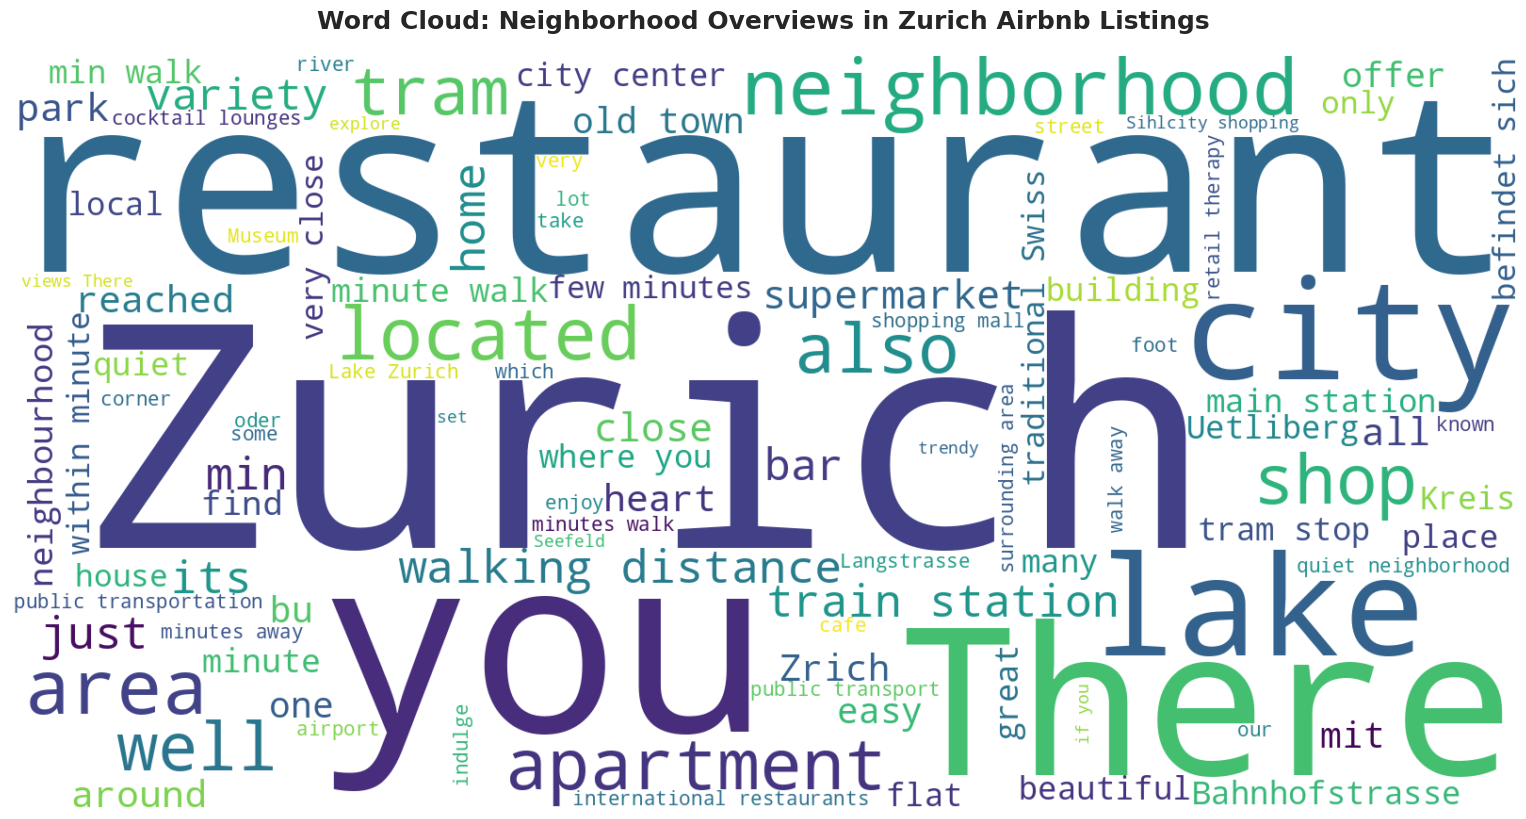

In [88]:
# Create word cloud
# Define common stopwords (including some German words common in Zurich)
stopwords = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
                 'of', 'with', 'is', 'are', 'was', 'were', 'been', 'be', 'have', 'has',
                 'br', 'b', 'it', 'this', 'that', 'from', 'as', 'by', 'can', 'will',
                 'der', 'die', 'das', 'und', 'ist', 'ein', 'eine', 'zu', 'den', 'dem'])

# Generate word cloud
wordcloud = WordCloud(width=1600, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10,
                      colormap='viridis',
                      relative_scaling=0.5,
                      max_words=100).generate(all_text)

# Display word cloud
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Neighborhood Overviews in Zurich Airbnb Listings',
          fontsize=18, fontweight='bold', pad=20)
plt.tight_layout(pad=0)
plt.savefig('output/word_cloud.png', dpi=300, bbox_inches='tight')
plt.show()

In [89]:
# Extract and display top keywords
from collections import Counter

# Tokenize and count words
words = all_text.lower().split()
words = [w for w in words if w not in stopwords and len(w) > 3]
word_freq = Counter(words)

print("\nTop 30 Most Frequent Terms in Neighborhood Descriptions")
print("\nRank | Word | Frequency")

for idx, (word, count) in enumerate(word_freq.most_common(30), 1):
    print(f"{idx:3d}  | {word:20s} | {count:5d}")


Top 30 Most Frequent Terms in Neighborhood Descriptions

Rank | Word | Frequency
  1  | zurich               |   630
  2  | restaurants          |   589
  3  | city                 |   423
  4  | minutes              |   420
  5  | there                |   399
  6  | zrich                |   368
  7  | tram                 |   336
  8  | area                 |   335
  9  | walk                 |   320
 10  | neighborhood         |   314
 11  | lake                 |   309
 12  | station              |   309
 13  | apartment            |   299
 14  | located              |   293
 15  | bars                 |   287
 16  | also                 |   279
 17  | train                |   266
 18  | shopping             |   249
 19  | shops                |   235
 20  | close                |   233
 21  | within               |   231
 22  | away                 |   229
 23  | very                 |   223
 24  | walking              |   222
 25  | district             |   219
 26  | just       

### Word Cloud Analysis Findings

**Emphasized Terms and Their Significance:**

The word cloud generated from neighborhood overviews reveals the key selling points that Zurich hosts emphasize when describing their areas:

**Location and Accessibility Dominate the Discourse (Top 15 Words):**

The most frequent terms overwhelmingly emphasize proximity and connectivity:

- **"Zurich" (630 occurrences)** and **"Zürich" (368)** appear constantly as hosts orient travelers to the city
- **"Restaurants" (589)** is the #2 most frequent word—hosts aggressively market dining options
- **"City" (423)** and **"minutes" (420)** appear together constantly in phrases like "5 minutes from city center"
- **"Tram" (336)**, **"walk" (320)**, **"station" (309)**, and **"train" (266)** form a transportation vocabulary cluster, appearing in nearly every listing
- **"Lake" (309)** ranks 11th—Lake Zurich is a consistent selling point even for properties not directly on the water
- **"Close" (233)**, **"within" (231)**, **"away" (229)**, and **"distance" (189)** create a semantic field of proximity marketing

This vocabulary cluster reveals that **walkability and transit access are THE primary value propositions** for Zurich Airbnb hosts. Nearly every description follows the formula: "Located [X] minutes walk/tram from [attraction]."



**Amenities and Lifestyle - The Social Experience:**

Beyond transportation, hosts emphasize urban lifestyle amenities:

- **"Restaurants" (589)** + **"Bars" (287)** + **"Shopping" (249)** + **"Shops" (235)** paint a picture of vibrant neighborhood life
- **"Cafés"** appears smaller but still prominent, targeting a specific traveler seeking European café culture
- **"Supermarket"** is visible, addressing practical concerns about groceries 
- The visual prominence of **"you"** (bright yellow, large font) indicates hosts use second-person narrative extensively—"you can walk," "you will find," "you can enjoy"

**Neighborhood Character - The Dual Promise:**

Hosts attempt to balance two potentially contradictory appeals:

- **"Quiet" (177)** appears frequently, suggesting many travelers seek peaceful retreats
- **"Vibrant," "lively,"** and **"trendy"** also appear, targeting those seeking energy
- **"Neighborhood" (314)** itself ranks 10th, with hosts emphasizing distinct local character rather than generic urban amenities
- **"Traditional"** and **"Swiss"** appear, marketing authentic local experience
- **"Beautiful"** is prominently visible, appealing to aesthetic expectations

**Geographic Specificity:**

Unlike generic descriptions, Zurich hosts frequently name-drop specific locations:
- **"Wiedikon" (185)** appears in the top 30, indicating hosts in this neighborhood heavily emphasize its name recognition
- **"Langstrasse"** and **"Seefeld"** are both visible in the cloud
- **"Bahnhofstrasse"** (Zurich's famous shopping street) appears
- **"Old town"** is mentioned, likely referring to Altstadt

This geographic specificity suggests sophisticated marketing—hosts understand that certain neighborhood names carry cachet with informed travelers.

**Quantified Convenience - The "Minutes Walk" Formula:**

The frequency of measurement terms reveals a standardized marketing language:

- **"Minutes" (420)** + **"walk/walking" (320+222)** + **"distance" (189)** appear constantly together
- This creates formulaic descriptions: "5 minutes walk to lake," "10 minutes to city center"
- The emphasis on precise walking times suggests travelers prioritize specific, verifiable proximity claims over vague "nearby" statements

**Missing or Underemphasized Terms:**

Interestingly, certain words are conspicuously absent or small:

- **Price/value terms** barely appear—hosts don't compete on affordability in descriptions
- **WiFi** is smaller than expected, perhaps assumed as standard
- **Parking** is relatively small, reflecting Zurich's car-optional urban culture
- **Safety/security** terms are minimal, possibly indicating Zurich's baseline safety 
  reputation

**Bilingual/Swiss Elements:**

The presence of both "Zurich" and "Zürich" (with umlaut) reflects the bilingual nature of Swiss tourism marketing, though English dominates the corpus.

### Interpretation:

The word cloud essentially maps **the language of Zurich tourism marketing**. Hosts have converged on a common vocabulary emphasizing:

1. **Walkable proximity** to transportation, lake, and city center (top priority)
2. **Dining and nightlife** as lifestyle amenities (restaurants/bars dominate)
3. **Neighborhood character** with named districts adding specificity
4. **Quantified convenience** with precise distance claims

Notably absent are negative qualifiers or caveats—the text corpus is overwhelmingly promotional. Hosts understand that travelers make decisions based on **location verifiability** (can I walk to the lake in 10 minutes?) and **lifestyle aspirations** (can I enjoy restaurants and cafés nearby?). Understanding these linguistic patterns helps both travelers decode marketing speak and hosts optimize their own descriptions to match market expectations.

The prominence of second-person address ("you") shows hosts write in an intimate, direct style—not listing features but painting scenarios: "You'll enjoy..." rather than "The apartment has..." This reflects best practices in experiential marketing.

---
# Part 2: Prediction - Multiple Linear Regression

## 2.1 Building a Price Prediction Model

### Objective: Predict listing price based on property characteristics

Potential Numerical Predictors
['id', 'scrape_id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']

Rows available for regression: 2534


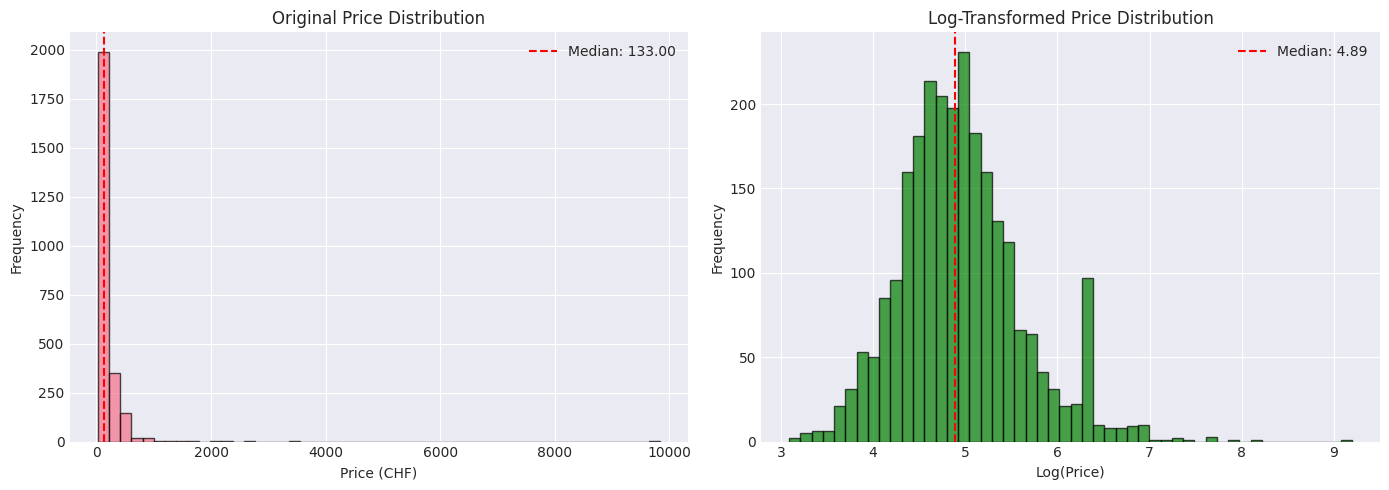

In [90]:
# Prepare data for regression
# First, let's explore potential predictor variables

print("Potential Numerical Predictors")
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print(numerical_cols[:20])

# Remove rows where price is missing or zero
df_regression = df_clean[(df_clean['price'].notna()) & (df_clean['price'] > 0)].copy()
print(f"\nRows available for regression: {len(df_regression)}")

# Explore price distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original price distribution
axes[0].hist(df_regression['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price (CHF)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Original Price Distribution')
axes[0].axvline(df_regression['price'].median(), color='red', linestyle='--', 
                label=f'Median: {df_regression["price"].median():.2f}')
axes[0].legend()

# Log-transformed price distribution
axes[1].hist(np.log(df_regression['price']), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log(Price)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Price Distribution')
axes[1].axvline(np.log(df_regression['price']).median(), color='red', linestyle='--', 
                label=f'Median: {np.log(df_regression["price"]).median():.2f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('output/price_distribution_histograms.png', dpi=300, bbox_inches='tight')
plt.show()


Starting with 2534 observations and 10 continuous predictors

Correlation with Price
price                     1.000000
accommodates              0.259760
availability_365          0.189749
beds                      0.182669
bathrooms_clean           0.158001
bedrooms                  0.140232
review_scores_rating      0.022982
review_scores_location    0.019871
review_scores_value      -0.004835
number_of_reviews        -0.038515
minimum_nights           -0.041090
Name: price, dtype: float64


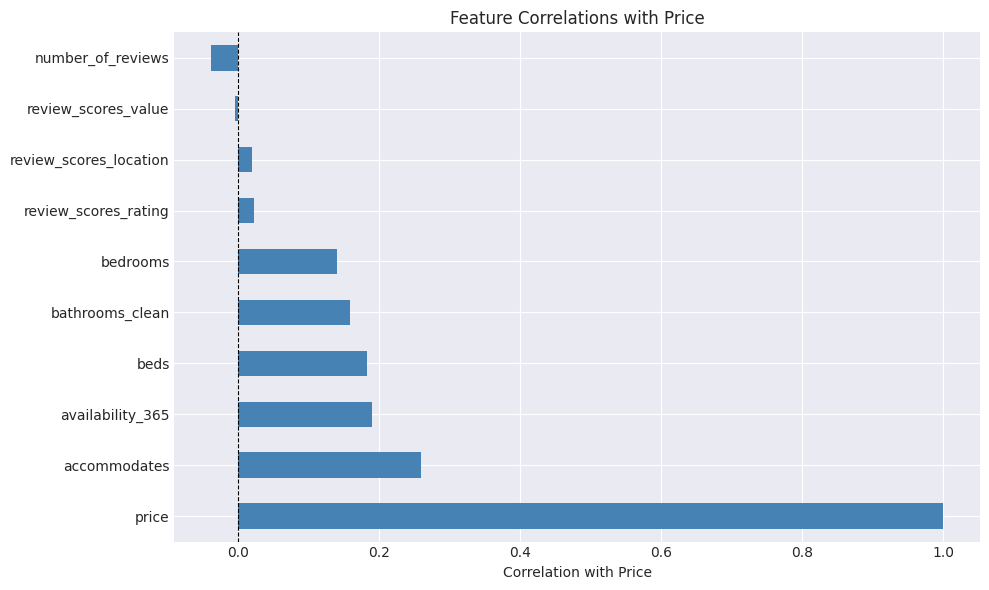

In [91]:
# Feature engineering and selection
# Create dummy variables for categorical predictors

# Select candidate predictors
# Continuous variables
continuous_predictors = [
    'accommodates', 'bedrooms', 'beds', 'bathrooms_clean',
    'number_of_reviews', 'review_scores_rating',
    'review_scores_location', 'review_scores_value',
    'availability_365', 'minimum_nights'
]

# Categorical variables
categorical_predictors = ['room_type', 'neighbourhood_cleansed']

# Create feature dataframe
df_model = df_regression[continuous_predictors + categorical_predictors + ['price']].copy()

# Handle any remaining missing values in predictors
for col in continuous_predictors:
    df_model[col] = df_model[col].fillna(df_model[col].median())

print(f"Starting with {len(df_model)} observations and {len(continuous_predictors)} continuous predictors")

# Check correlations with price
print("\nCorrelation with Price")
correlations = df_model[continuous_predictors + ['price']].corr()['price'].sort_values(ascending=False)
print(correlations)

# Visualize correlations
plt.figure(figsize=(10, 6))
correlations[:-1].plot(kind='barh', color='steelblue')
plt.xlabel('Correlation with Price')
plt.title('Feature Correlations with Price')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.savefig('output/correlation_with_price.png')
plt.show()

In [92]:
# Create dummy variables for categorical features
# For room_type (small number of categories, keep all)
room_type_dummies = pd.get_dummies(df_model['room_type'], prefix='room', drop_first=True)

# For neighborhood, keep only top 10 to avoid too many features
# Combine less common neighborhoods into 'Other'
top_neighborhoods = df_model['neighbourhood_cleansed'].value_counts().head(10).index
df_model['neighborhood_grouped'] = df_model['neighbourhood_cleansed'].apply(
    lambda x: x if x in top_neighborhoods else 'Other'
)
neighborhood_dummies = pd.get_dummies(df_model['neighborhood_grouped'], prefix='nbhd', drop_first=True)

# Combine all features
X = pd.concat([
    df_model[continuous_predictors],
    room_type_dummies,
    neighborhood_dummies
], axis=1)

y = df_model['price']
y_log = np.log(df_model['price'])

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Features included: {X.columns.tolist()}")


Final feature matrix shape: (2534, 23)
Features included: ['accommodates', 'bedrooms', 'beds', 'bathrooms_clean', 'number_of_reviews', 'review_scores_rating', 'review_scores_location', 'review_scores_value', 'availability_365', 'minimum_nights', 'room_Hotel room', 'room_Private room', 'room_Shared room', 'nbhd_Altstetten', 'nbhd_Enge', 'nbhd_Langstrasse', 'nbhd_Oerlikon', 'nbhd_Other', 'nbhd_Rathaus', 'nbhd_Seefeld', 'nbhd_Sihlfeld', 'nbhd_Unterstrass', 'nbhd_Wollishofen']


In [93]:
# Check for multicollinearity
print("\nMulticollinearity Analysis\n")

# Method 1: Correlation-based check
print("Step 1: Checking correlations between features...")
correlation_matrix = X.corr().abs()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] > 0.85:
            high_corr_pairs.append({
                'Feature1': correlation_matrix.columns[i],
                'Feature2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("\nHighly correlated feature pairs (>0.85):")
    for pair in high_corr_pairs:
        print(f"  {pair['Feature1']} <-> {pair['Feature2']}: {pair['Correlation']:.3f}")

# Method 2: Try VIF calculation with error handling
print("\nStep 2: Attempting VIF calculation...")

# Clean data first
X_vif = X.copy()
X_vif = X_vif.replace([np.inf, -np.inf], np.nan)
X_vif = X_vif.fillna(X_vif.median())

# Remove constant columns
constant_cols = X_vif.columns[X_vif.std() == 0].tolist()
if constant_cols:
    print(f"  Removing constant columns: {constant_cols}")
    X_vif = X_vif.drop(columns=constant_cols)

try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_vif.columns
    vif_values = []
    
    for i in range(X_vif.shape[1]):
        try:
            vif = variance_inflation_factor(X_vif.values, i)
            if np.isnan(vif) or np.isinf(vif):
                vif_values.append(999)  # Large placeholder for problematic features
            else:
                vif_values.append(vif)
        except:
            vif_values.append(999)
    
    vif_data["VIF"] = vif_values
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    print("\nVIF Results (High VIF >10 indicates multicollinearity):")
    print(vif_data.head(10))
    
    high_vif_features = vif_data[vif_data['VIF'] > 10]['Feature'].tolist()
    
except Exception as e:
    print(f"  VIF calculation failed: {str(e)}")
    print("  Using correlation analysis instead.")
    high_vif_features = []

# Decide which features to remove
print("\nFeature Selection Decision")
features_to_remove = []

# Priority 1: Remove 'beds' if it has issues
if 'beds' in X.columns:
    if high_corr_pairs and any('beds' in [p['Feature1'], p['Feature2']] for p in high_corr_pairs):
        features_to_remove.append('beds')
        print("Removing 'beds': highly correlated with bedrooms/accommodates")
    elif 'beds' in high_vif_features:
        features_to_remove.append('beds')
        print("Removing 'beds': high VIF detected")

# Remove selected features
if features_to_remove:
    X = X.drop(columns=features_to_remove)
    print(f"\nFeatures removed: {features_to_remove}")
    print(f"Remaining features ({len(X.columns)}): {X.columns.tolist()}")
else:
    print("No features need to be removed")
    print(f"All features retained ({len(X.columns)})")

print(f"\nFinal feature matrix shape: {X.shape}")


Multicollinearity Analysis

Step 1: Checking correlations between features...

Step 2: Attempting VIF calculation...

VIF Results (High VIF >10 indicates multicollinearity):
                  Feature  VIF
0            accommodates  999
1                bedrooms  999
2                    beds  999
3         bathrooms_clean  999
4       number_of_reviews  999
5    review_scores_rating  999
6  review_scores_location  999
7     review_scores_value  999
8        availability_365  999
9          minimum_nights  999

Feature Selection Decision
Removing 'beds': high VIF detected

Features removed: ['beds']
Remaining features (22): ['accommodates', 'bedrooms', 'bathrooms_clean', 'number_of_reviews', 'review_scores_rating', 'review_scores_location', 'review_scores_value', 'availability_365', 'minimum_nights', 'room_Hotel room', 'room_Private room', 'room_Shared room', 'nbhd_Altstetten', 'nbhd_Enge', 'nbhd_Langstrasse', 'nbhd_Oerlikon', 'nbhd_Other', 'nbhd_Rathaus', 'nbhd_Seefeld', 'nbhd_Sihlfel